In [24]:

import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
import datetime
from numpy.linalg import LinAlgError
import seaborn as sns
import itertools
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta



In [9]:

df = pd.read_csv('raw_sales.csv')

In [ ]:
df.info()
df.head()

In [10]:
df['datesold'] = pd.to_datetime(df['datesold'])
df.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07,2607,525000,house,4
1,2007-02-27,2906,290000,house,3
2,2007-03-07,2905,328000,house,3
3,2007-03-09,2905,380000,house,4
4,2007-03-21,2906,310000,house,3


In [ ]:
df['datesold'].sort_values()

## the sales dates are from 2007 to 2019

In [11]:
## possible postcode values
df.postcode.sort_values().unique()
## we can group postcode into two, one starting with 26 and the other starting with 29

df['postcode_cat'] = ['29**'] * len(df)
pos = df['postcode'] < 2700
df.loc[pos, 'postcode_cat'] = ['26**'] * pos.sum()

df.postcode_cat.value_counts(normalize=True)

26**    0.59574
29**    0.40426
Name: postcode_cat, dtype: float64

In [8]:
df.propertyType.value_counts(normalize= True)

house    0.83002
unit     0.16998
Name: propertyType, dtype: float64

In [61]:
df.bedrooms.value_counts()

3    11921
4    10389
2     3596
5     1898
1     1626
0       30
Name: bedrooms, dtype: int64

In [ ]:
plt.figure(figsize=(15,5))
plt.plot_date(df['datesold'], df['price'], xdate=True, markersize=1)
plt.xlabel('datesold')
plt.ylabel('price')
plt.show()

## there are some outliers, we can get rid of them. From the picture, 2* 10^6 is a good dividing line
## get rid of the outliers
threshold = 2* 10**6
df = df[df['price'] <= threshold]

In [10]:
## there are two pictures: the first one is displaying the prices along the date according to different categories
## the second is group the date points by the date, and displaying the average price
def alldata_visulization( col,df = df):
    col_values = df[col].sort_values().unique()
    fg = sns.FacetGrid(data=df, hue=col, hue_order=col_values, aspect=2, height=8)
    fg.map(plt.scatter, 'datesold', 'price', alpha=.7, s=5).add_legend()


## we can group by multiple cols using group by
def mean_visuallization(col,df = df, colors =['grey', 'orange','green','red','blue','purple','black','yellow']):
    col_values = df[col].sort_values().unique()
    a = df.groupby(by = [col,'datesold']).price.mean()
    plt.figure(figsize=(15,5))
    for i, val in enumerate(col_values):
        val_a = a[a.index.get_level_values(col) == val]
        plt.plot_date( val_a.index.get_level_values('datesold'), val_a.values, color = colors[i], 
            label = col +':' + str(val), alpha = 0.7, markersize= 2)
    
    plt.legend()
    plt.xlabel('datesold')
    plt.ylabel('price')
    plt.show()
    








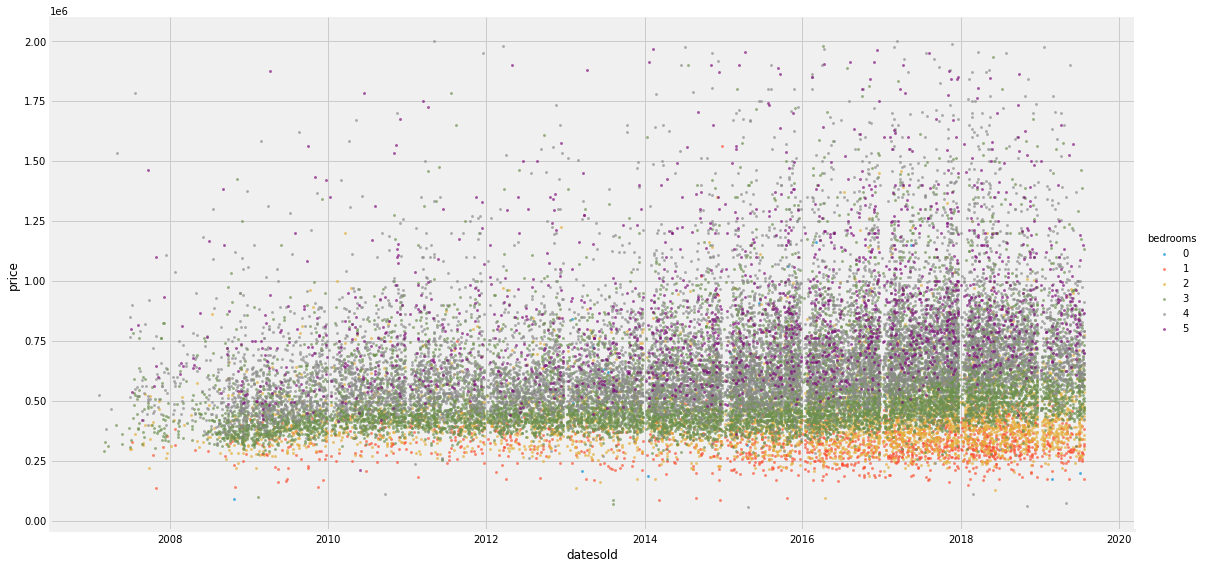

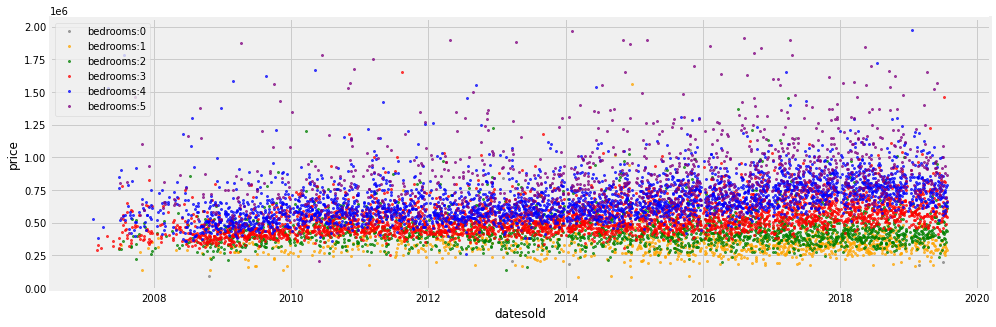

In [11]:
## next we would like to plot the data according to different postcodes, property types and number of bedrooms

alldata_visulization('bedrooms')
mean_visuallization('bedrooms')





From the picture above, we can see the house price is related to its number of bedrooms

In [ ]:

alldata_visulization('postcode_cat')
mean_visuallization('postcode_cat')


From above two pictures, we can see the postcodes are not closely related to the house prices.

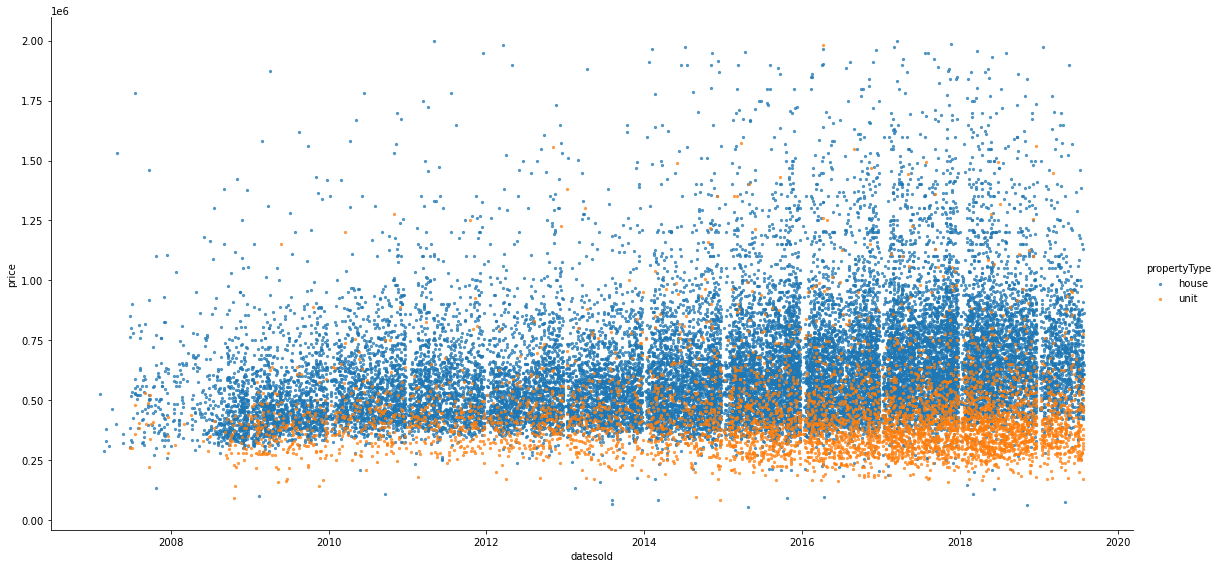

In [20]:
alldata_visulization('propertyType')
mean_visuallization('propertyType')

The prices are significantly different for different propertytypes. 
The propertytypes maybe closely related to the number of bedrooms. Housese usually have more bedrooms, while units have less.

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

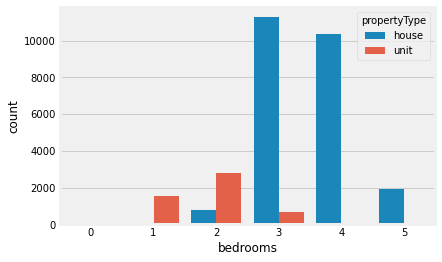

In [18]:
sns.countplot(x = 'bedrooms', hue = 'propertyType', data = df)

## when there are two or three bedrooms, it can either be houses or unit. We would like to see in this case, whether there are huge differee between the price

In [ ]:
## bedrooms = 2, we check the difference of price for different housr types
alldata_visulization(col = 'propertyType', df = df[df['bedrooms'] == 2])
mean_visuallization(col = 'propertyType', df = df[df['bedrooms'] == 2])

#bedrooms = 3
alldata_visulization(col = 'propertyType', df = df[df['bedrooms'] == 3])
mean_visuallization(col = 'propertyType', df = df[df['bedrooms'] == 3])


In [ ]:
alldata_visulization(col = 'bedrooms', df = df[(df['bedrooms'] <= 5) & (df['bedrooms'] >= 4)])
mean_visuallization(col = 'bedrooms', df = df[(df['bedrooms'] <= 5) & (df['bedrooms'] >= 4)])

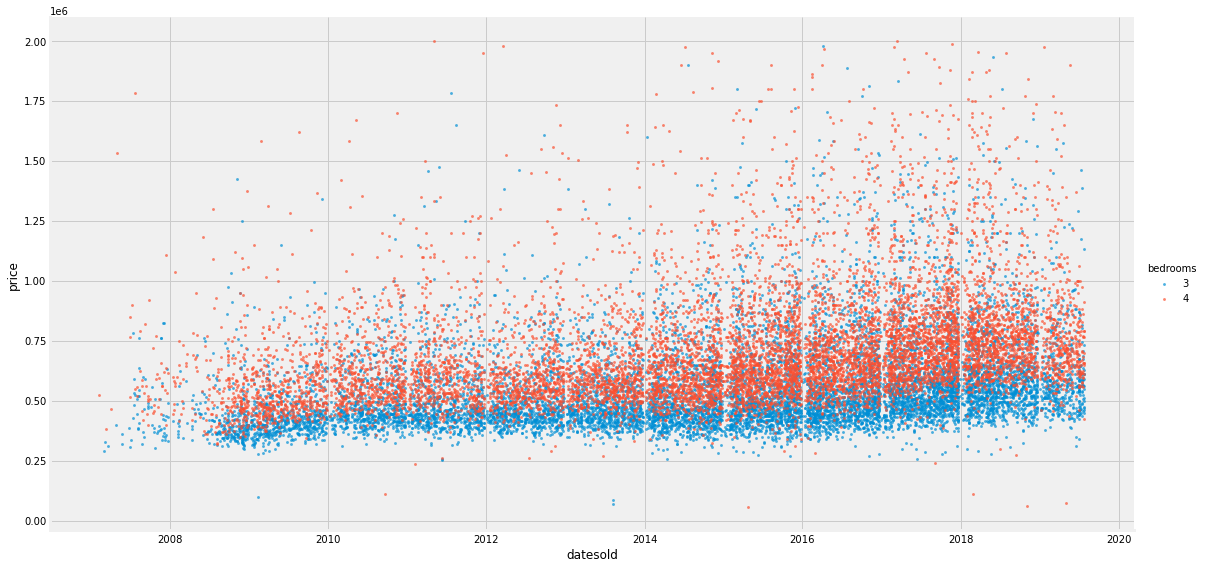

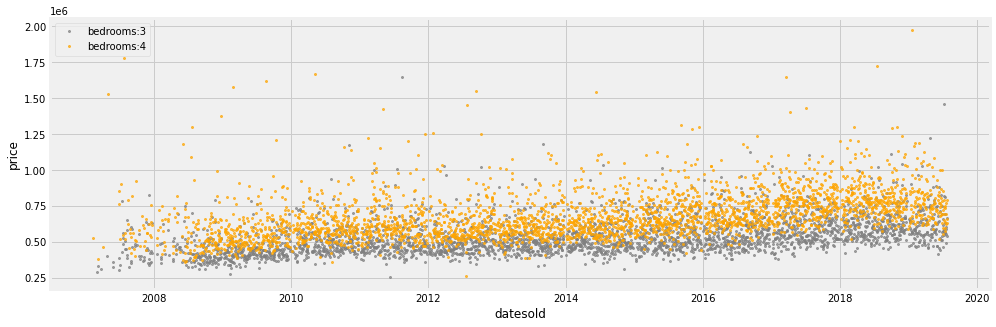

In [71]:
alldata_visulization(col = 'bedrooms', df = df[(df['bedrooms'] <= 4) & (df['bedrooms'] >= 3)])
mean_visuallization(col = 'bedrooms', df = df[(df['bedrooms'] <= 4) & (df['bedrooms'] >= 3)])

In [ ]:
alldata_visulization(col = 'bedrooms', df = df[(df['bedrooms'] <= 3) & (df['bedrooms'] >= 2)])
mean_visuallization(col = 'bedrooms', df = df[(df['bedrooms'] <= 3) & (df['bedrooms'] >= 2)])

In [ ]:
alldata_visulization(col = 'bedrooms', df = df[(df['bedrooms'] <= 2) & (df['bedrooms'] >= 1)])
mean_visuallization(col = 'bedrooms', df = df[(df['bedrooms'] <= 2) & (df['bedrooms'] >= 1)])

From the graphs, we can see that it is hard to observe the price differences caused by propertyType. Thus we can conclude the main factor for price differences is caused by bedroom numbers. From now on, we will concentrate only on price changes for different bedroom numbers.

There are only 30 properties with bedrooms 0, we can group bedroom 0 and bedroom 1 data together as bedroom 1. The new bedroom 1 and bedroom 2 are not easy to distinguish, we will group them together.
Bedroom 4 and bedroom 5 data are hard to distinguish, we will group them together.

In [13]:
df.loc[df['bedrooms']<2,'bedrooms'] = 2
df.loc[df['bedrooms']>4,'bedrooms'] = 4


In [13]:
df.bedrooms.value_counts()


4    12287
3    11921
2     5252
Name: bedrooms, dtype: int64

In [14]:
df = df.drop(['propertyType', 'postcode','postcode_cat'], axis = 1)

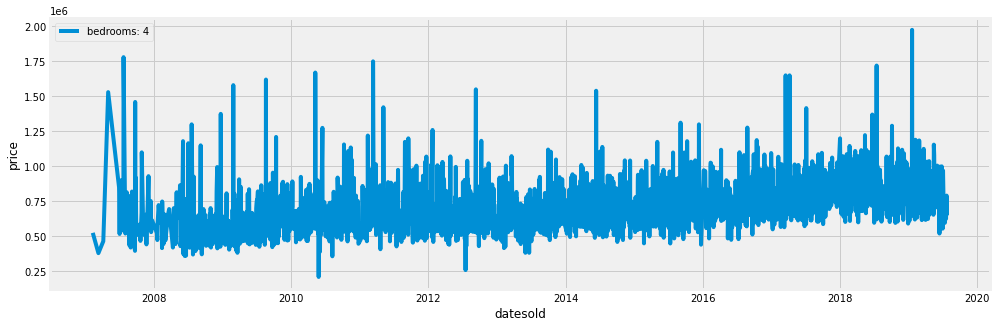

In [75]:
## we draw the prices per day for houses with 4 bedroom.
## we can see there are too many data and we would like to downsample the data with different frequency
df_bedroom_4 = df[df['bedrooms']==4].groupby('datesold').price.mean()
plt.figure(figsize = (15,5))
plt.plot(df_bedroom_4.index,df_bedroom_4.values, linestyle= 'solid', label = 'bedrooms: 4')
plt.legend()
plt.xlabel('datesold')
plt.xticks()
plt.ylabel('price')
plt.show()

In [15]:


## here we are downsampling the data, using different time bins, depending on different bedrooms

def downsample(time_bin , df = df, col = 'bedrooms'):
    col_values = df[col].sort_values().unique()
    new_df = pd.DataFrame()
    for col_val in col_values:
        df_val = df.loc[df[col] == col_val, ['datesold','price']]
        a = df_val.resample(on = 'datesold',rule = time_bin, label = 'left')
        df_val = a.mean().rename(columns ={'price' : time_bin + '_average_price'})
        df_val['num_properties'] = a.count().datesold.values
        df_val['bedrooms'] = [col_val]*len(df_val)

        new_df = pd.concat([new_df, df_val])
        new_df.fillna(0, inplace=True)
        new_df.index =  pd.DatetimeIndex( new_df.index.values, freq = new_df.index.inferred_freq)

    return new_df

In [ ]:
new_df = downsample('M')
new_df.head()

In [17]:

## plot the trend
def plot_trend(df, col,bedrooms):
    pos = df['bedrooms']== bedrooms

    fig, axs = plt.subplots(2,1, figsize = (15,10))
    axs[0].plot_date(df[pos].index,df.loc[pos,col], xdate = True, marker = '',linestyle= 'solid', label = 'bedrooms:' +str(bedrooms))
    axs[0].set_title('Price trend for bedrooms: '+ str(bedrooms))
    axs[0].legend()
    axs[0].set_xlabel('datesold')
    axs[0].set_ylabel(col)

    axs[1].plot_date(df[pos].index,df.loc[pos,'num_properties'], xdate = True, marker = '',linestyle= 'solid', label = 'bedrooms:' +str(bedrooms))
    axs[1].set_title('number of houses sold for bedrooms: '+ str(bedrooms))
    axs[1].legend()
    axs[1].set_xlabel('datesold')
    axs[1].set_ylabel('num of houses sold')

    
    # dtFmt = mdates.DateFormatter('%y-%m') # define the formatting
    # plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
    plt.show()

In [ ]:
plot_trend(new_df, col = "M_average_price", bedrooms = 2)

In [ ]:
plot_trend(new_df, col = 'M_average_price', bedrooms= 3)

In [ ]:
plot_trend(new_df, col = 'M_average_price', bedrooms= 4)

At least, we can see the number of properties sold has a seasonal trend of a year.
For the three price time series, there are a little trends of price increasing.

From the graphs on the second row, there is an obvious one-year period in the number of sold houses. So we assume there is a one-year period for price.
We first do the seasonal decompositions using one-year period. We would like to predict the de seasonal data using ARIMA model. The data is divide into train and cross validation set.
The train set is to find the best ARIMA model under the AIC or RMSE measurement. 

In [17]:
df_2 = new_df.loc[new_df['bedrooms'] == 2,'M_average_price']
df_3 = new_df.loc[new_df['bedrooms'] == 3,'M_average_price']
df_4 = new_df.loc[new_df['bedrooms'] == 4,'M_average_price']
dfs = [df_2,df_3,df_4]

In [ ]:
## seasonal decomposition 
deseasonal_df = []
seasonals = []
seasonal_period = 12
for i,df_i in enumerate(dfs):
    
    decomp = sm.tsa.seasonal_decompose(df_i, period = seasonal_period)
    deseasonal_df.append( df_i - decomp.seasonal)
    seasonals.append(decomp.seasonal)
    plt.rcParams['figure.figsize'] = (14, 9)
    decomp.plot()
    plt.show()

    



In [80]:
## times series after differencing several times
def diffed_data(dfs, diff_num ):
    diff_dfs = []
    for i, df in enumerate(dfs):
        diff_df = df.diff(diff_num)
        diff_df.fillna(0,inplace = True)
        diff_dfs.append(diff_df)
        plt.figure(figsize = (12,4))
        plt.plot_date(diff_df.index, diff_df.values,xdate = True, marker = '',linestyle= 'solid', label = 'bedrooms' + str(i+2))
        plt.title("time series after differencing " + str(diff_num))
        plt.legend()
        plt.show()
    return diff_dfs

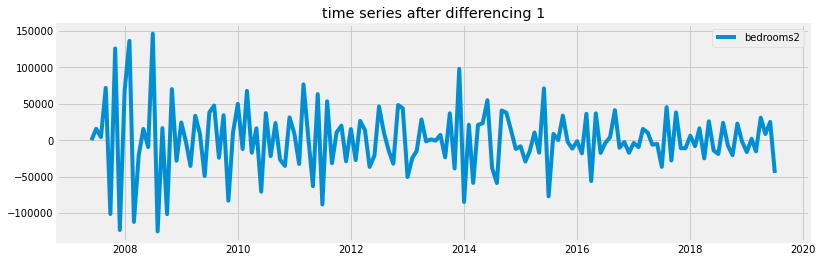

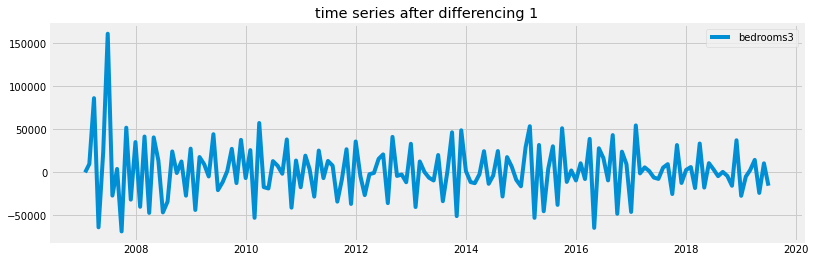

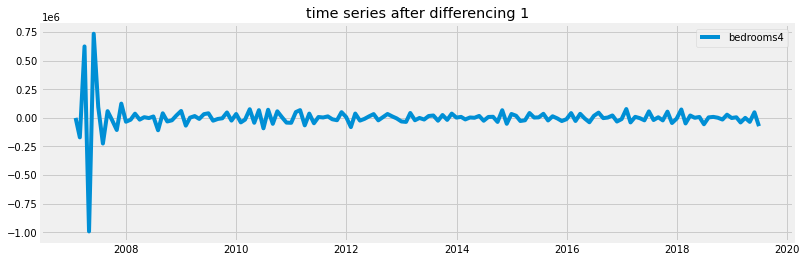

In [81]:
diff_dfs = diffed_data(deseasonal_df, 1)

We can see after one difference, the data seems already stationary. Thus we set maximal number of differences to be 1.

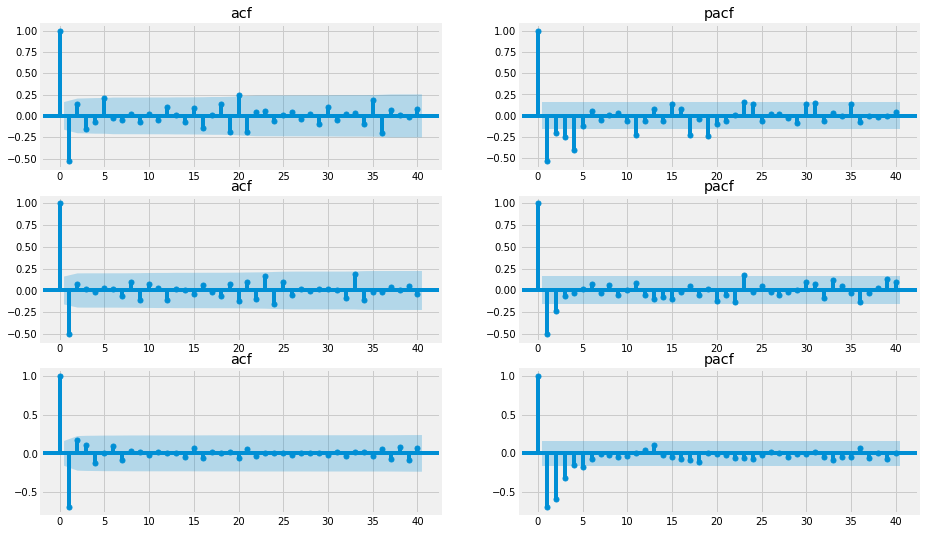

In [82]:
## here we use acf and pacf to get a rough range for the parameters in ARIMA models
fig, ax = plt.subplots(len(diff_dfs),2)
for i,n_df in enumerate(diff_dfs):
    # print("***************************************************************************")
    sm.graphics.tsa.plot_acf(n_df, lags=40, ax=ax[i,0],title="acf")
    sm.graphics.tsa.plot_pacf(n_df, lags=40, ax=ax[i,1],title="pacf")      
    
plt.show()


In [118]:
## from above analysis, autocorrelation gives q, partial correlation gives p
max_p = 5
max_q = 2
max_d = 1
parameters = itertools.product(range(0,max_p + 1),range(0,max_d + 1) , range(0,max_q + 1))

ps = list(parameters)

In [119]:
def measure_dic(keys = [2,3,4], pars = ( max_p + 1 , max_d + 1, max_q + 1)):
    dic = {}
    for key in keys:
        dic[key] = np.ones(pars) * float('inf')
    return dic

aics = measure_dic()
rmses = measure_dic()

In [ ]:
## fit in the ARIMA model
## when differencing is applied


for x in ps:
    if x == (0,0,0) or x == (0,1,0):
        continue
    for s, n_df in enumerate(deseasonal_df):
        try: 
            sales = ARIMA(n_df, order= x, freq = 'M') 
            res = sales.fit()
            # print(res.summary(), " for " + str(s + 2) + "bedrooms")
            y_pred = res.predict()
            f = pd.merge(y_pred.rename('pred'),n_df.rename('observe'),left_index=True,right_index= True)
            rmse = math.sqrt(mean_squared_error(f['pred'],f['observe']))
            rmses[s+2][x[0],x[1],x[2]] = rmse
            aics[s+2][x[0],x[1],x[2]] = res.aic
            # print("**************************************************")
            # print('ARIMA model of order',x, 'for bedrooms ' + str(s + 2))
            # res.plot_predict()
            # plt.show()
        except (ValueError, LinAlgError): 
            print(s,x)
            pass
        

In [122]:
## find the model with the smallest AIC or MSE

for i in range(len(deseasonal_df)):
    aic_par = np.argwhere(aics[i+2]== np.min(aics[i+2]))
    print('For ' + str(i + 2) + 'bedrooms, then ARIMA model with minimum AIC is', aic_par)
    msr_par = np.argwhere(rmses[i+2]== np.min(rmses[i+2]))
    print('For ' + str(i + 2) + 'bedrooms, then ARIMA model with minimum RMES is', msr_par)






For 2bedrooms, then ARIMA model with minimum AIC is [[5 1 1]]
For 2bedrooms, then ARIMA model with minimum RMES is [[5 0 2]]
For 3bedrooms, then ARIMA model with minimum AIC is [[0 1 1]]
For 3bedrooms, then ARIMA model with minimum RMES is [[4 0 1]]
For 4bedrooms, then ARIMA model with minimum AIC is [[5 1 0]]
For 4bedrooms, then ARIMA model with minimum RMES is [[4 0 1]]


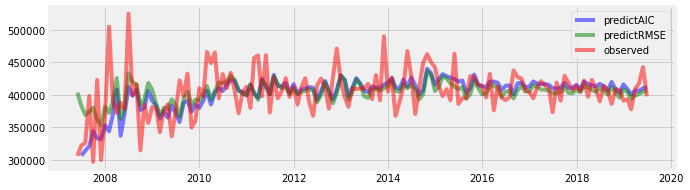

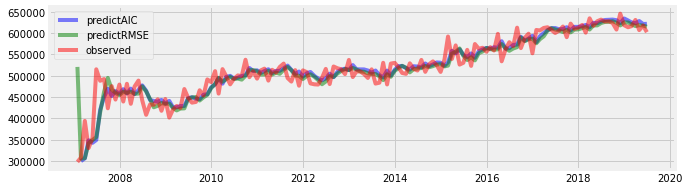

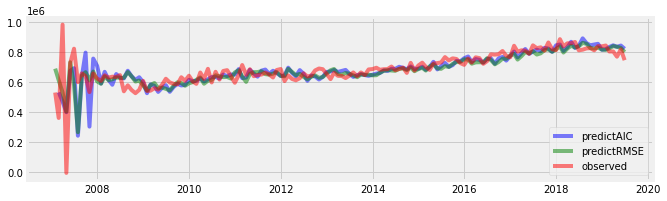

In [123]:

## notice that when predict is used, do not forget set typ as "levels", 
# otherwise the differeced values are returned
measures = ['AIC','RMSE']
def check_performances(df,parameters, measures= measures):
    fig = plt.figure(figsize=(10,3))
    colors = ['blue','green']
    for i in range(2):
        pred_model = ARIMA(df,order = parameters[i],freq = 'M')
        res = pred_model.fit()
        y_pred = res.predict(typ= 'levels')
        # res.plot_predict()
        # plt.show()
        plt.plot(y_pred.index ,y_pred.values, label = 'predict' +  measures[i], color = colors[i], alpha = 0.5)
    plt.plot(df.index, df.values, label = 'observed', color = 'red', alpha = 0.5)
    plt.legend()
    plt.show()

AIC_parameters = [(5,1,1),(0,1,1),(5,1,0)]

rmse_parameters = [(5,0,2),(4,0,1),(4,0,1)]

for i in range(len(deseasonal_df)):
    check_performances(deseasonal_df[i],[AIC_parameters[i],rmse_parameters[i]])
    
    


It seems that the major differences between these two models are the beginning part, and AIC performs better at the beginning part. So we will choose the best model according to AIC.

In [51]:
## predict the sales price after knowing the bedrooms
def sales_predict(bedroom_num, time_step = 1, parameters = [(5,1,1),(0,1,1),(5,1,0)], past_sales = deseasonal_df ,seasonal_components = seasonals):
    i = bedroom_num
    if bedroom_num <= 2:
        i = 2
    elif bedroom_num >=4:
        i = 4
    model = ARIMA(past_sales[i-2],order = parameters[i-2], freq = 'M')
    res = model.fit()
    pred_price = res.forecast(steps = time_step)[0]
    date = past_sales[i-2].index[-1] + relativedelta(months=time_step) 
    s = seasonal_components[i-1].head(12)
    # print(pred_price)
    pred_price += s[s.index.month == date.month].values
    # print(pred_price)
    print("The predicted price of a house with %d bedroom at %d-%d is %.1f" %(bedroom_num,date.year, date.month,round(pred_price[0],0)))
    return round(pred_price[0],0)

    

In [52]:
sales_predict(1)


The predicted price of a house with 1 bedroom at 2019-7 is 401460.0


401460.0